# MINERIA DE DATOS - TUIA - 2024
## Trabajo práctico N° 2
### Estudiante: Yañez, Mirian

### El siguiente trabajo se realiza con los conjuntos de datos "1000_Companies.csv" y "PokemonDB.csv"

### Instalo las dependencias necesarias

In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import export_text
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

## Carga del dataset 1000 Companies

In [20]:
data = pd.read_csv('data/1000_Companies.csv')

### Información del dataset (datos nulos y tipos de datos por columna)

In [21]:
data.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


### Se puede observar que el dataset cuenta con un total de 1000 datos, los mismos son de tipo float64 y la variable State de tipo object.
### No hay valores nulos en ninguna de las variables

### Descripción estadística de los datos (min, max, media, mediana, etc.)

In [23]:
data.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


# Matriz de correlación

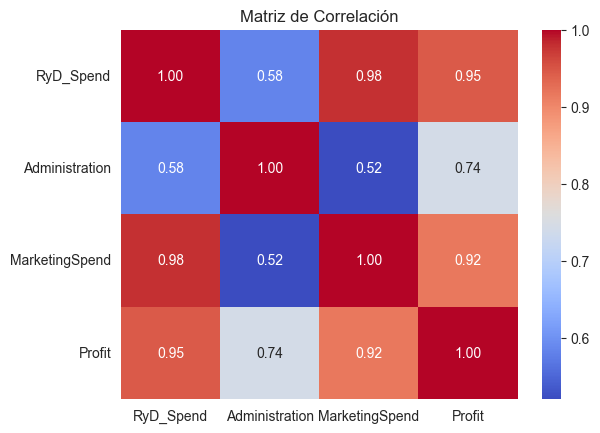

In [24]:
columnas_numericas = data.select_dtypes(include='number')

matriz_correlacion = columnas_numericas.corr()

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.ylim(len(matriz_correlacion), 0)
plt.xlim(0, len(matriz_correlacion))
plt.title("Matriz de Correlación")
plt.show()

### Se puede observar que hay una correlación lineal positiva muy buena entre todas las variables

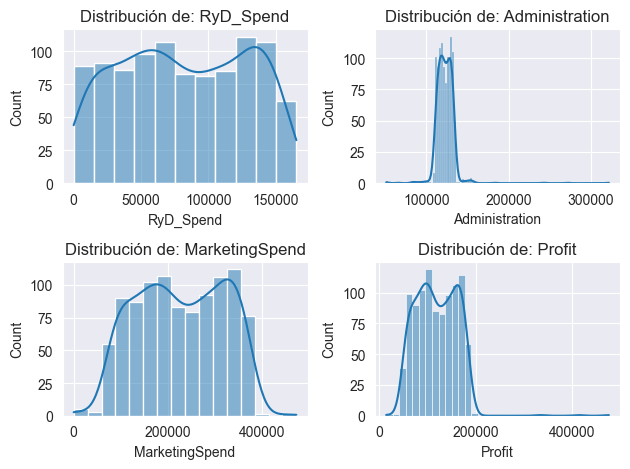

In [25]:
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribución de: {column}')
plt.tight_layout()
plt.show()

En los histogramas puedo observar que las distribuciones se asemejan a la normal y hay 2 variables que presentan un sesgo hacia la derecha. 

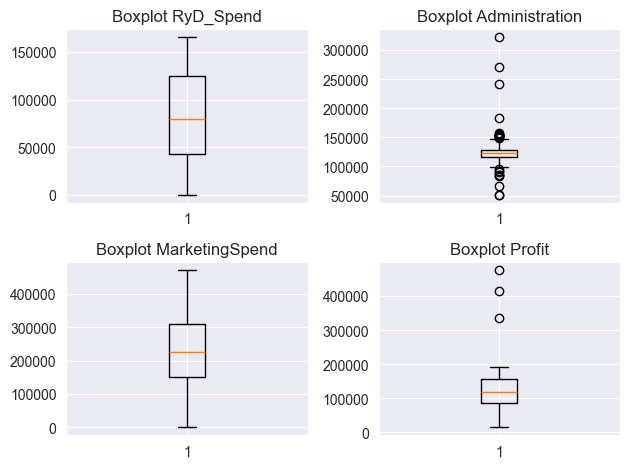

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [26]:
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(2, 2, i + 1)
    plt.boxplot(data[column])
    plt.title(f'Boxplot {column}')

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))

## Se observa presencia de valores que aparentan ser outliers en las variables Administration y Profit

## Outliers

In [27]:
def cantidad_outliers(column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = ((data[column] < lower_bound) | (data[column] > upper_bound)).sum()
    return outliers_count

In [28]:
for column in columnas_numericas:
    outliers_count = cantidad_outliers(column)
    print(f'Cantidad de outliers en la columna {column}: {outliers_count}, porcentaje de outliers: {outliers_count*100/data.shape[0]} %')


Cantidad de outliers en la columna RyD_Spend: 0, porcentaje de outliers: 0.0 %
Cantidad de outliers en la columna Administration: 22, porcentaje de outliers: 2.2 %
Cantidad de outliers en la columna MarketingSpend: 0, porcentaje de outliers: 0.0 %
Cantidad de outliers en la columna Profit: 3, porcentaje de outliers: 0.3 %


## Dado que la cantidad de valores outliers representa menos del 3% total de los datos los elimino

In [29]:
def eliminar_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar el dataframe para excluir los outliers
    data_cleaned = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data_cleaned

# Iterar sobre las columnas numéricas y eliminar outliers
for column in columnas_numericas:
    data = eliminar_outliers(data, column)

### Observamos nuevamente su distribución

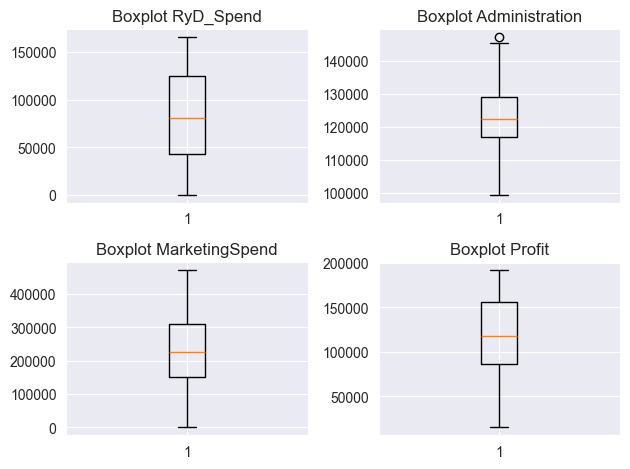

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [30]:
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(2, 2, i + 1)
    plt.boxplot(data[column])
    plt.title(f'Boxplot {column}')

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))

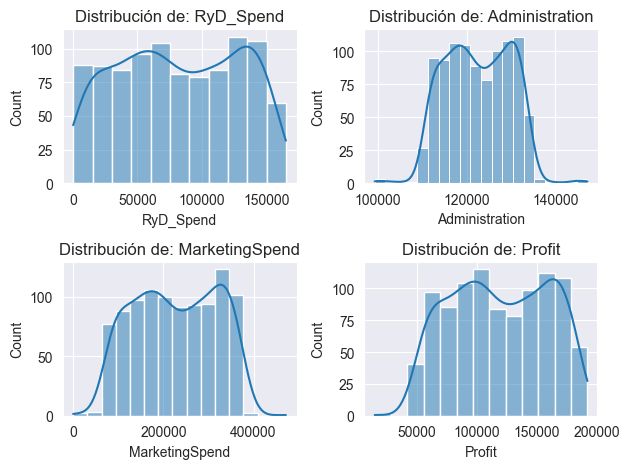

In [31]:
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribución de: {column}')
plt.tight_layout()
plt.show()

Se puede observar que los histogramas conservan su distribución pero sin el sesgo

# Estandarización

### Elijo el metodo minmax para realizar la estandarización 

In [32]:
columns_num= ['RyD_Spend', 'Administration', 'MarketingSpend', 'Profit']
scaler = MinMaxScaler()
data_scaler = scaler.fit_transform(data[columns_num])
data_scaled_df = pd.DataFrame(data_scaler, columns=columns_num)

# Regression Tree

### División train-test

In [33]:
y = data_scaled_df['Profit']
X = data_scaled_df.drop('Profit', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = tree.DecisionTreeRegressor(max_depth=6,min_samples_leaf=1, min_samples_split=2, random_state=13 )

regressor_tree = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

feature_list = list(X_train.columns)

r = export_text(regressor_tree, feature_names=feature_list)
print(r)

|--- RyD_Spend <= 0.50
|   |--- RyD_Spend <= 0.25
|   |   |--- RyD_Spend <= 0.13
|   |   |   |--- RyD_Spend <= 0.07
|   |   |   |   |--- Administration <= 0.25
|   |   |   |   |   |--- Administration <= 0.24
|   |   |   |   |   |   |--- value: [0.20]
|   |   |   |   |   |--- Administration >  0.24
|   |   |   |   |   |   |--- value: [0.22]
|   |   |   |   |--- Administration >  0.25
|   |   |   |   |   |--- MarketingSpend <= 0.41
|   |   |   |   |   |   |--- value: [0.24]
|   |   |   |   |   |--- MarketingSpend >  0.41
|   |   |   |   |   |   |--- value: [0.20]
|   |   |   |--- RyD_Spend >  0.07
|   |   |   |   |--- Administration <= 0.28
|   |   |   |   |   |--- Administration <= 0.28
|   |   |   |   |   |   |--- value: [0.26]
|   |   |   |   |   |--- Administration >  0.28
|   |   |   |   |   |   |--- value: [0.26]
|   |   |   |   |--- Administration >  0.28
|   |   |   |   |   |--- Administration <= 0.29
|   |   |   |   |   |   |--- value: [0.28]
|   |   |   |   |   |--- Administrat

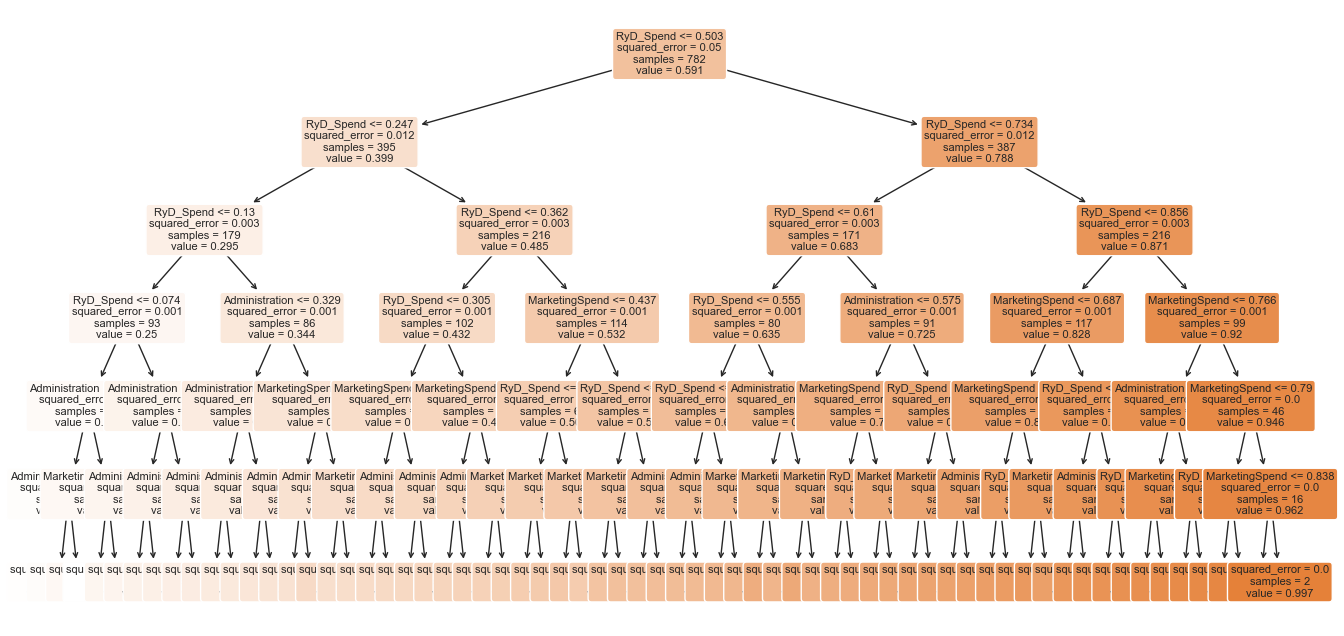

In [34]:
features = feature_list

plt.figure(figsize=(16,8))
tree.plot_tree(regressor_tree,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()

# Métricas

In [35]:
y_test = y_test.astype(float)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions) # medida de la bondad de ajuste del modelo

#primero calculamos el error absoluto porcentual (APE) para cada predicción y luego calculamos el MAPE promediando estos errores.
mape = np.mean(np.abs((y_test - predictions) / y_test) * 100)
# Calcular R-squared adjusted (R2 ajustado)
n = len(y_test)  # Número de observaciones
p = len(feature_list)  # Número de predictores (variables independientes)
r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))  # tiene en cuenta la complejidad del modelo al penalizar el uso excesivo de predictores
rmse = np.sqrt(mse)

# Imprimir MAPE
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)
print("R-squared adjusted (R2 ajustado):", r2_adjusted)
print("Root Mean Squared Error (RMSE):", rmse)



Mean Absolute Percentage Error (MAPE): inf
Mean Absolute Error (MAE): 0.005412255389906947
Mean Squared Error (MSE): 0.0003556141398587484
Root Mean Squared Error (RMSE): 0.018857734218583853
R-squared (R2): 0.9931894708896826
R-squared adjusted (R2 ajustado): 0.9930830563723338
Root Mean Squared Error (RMSE): 0.018857734218583853


### Observo en el árbol de decisión, sin optimización de hiperparámetros, que se sobreajusta (overfitting)

# Optimización de hiperparámetros

### Utilizo el método de gridsearch para optimizar los hiperparámetros

In [36]:
# Define un rango de hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    'max_depth': [1, 2],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Mejores hiperparámetros: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [37]:
y_test = y_test.astype(float)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred) # medida de la bondad de ajuste del modelo

#primero calculamos el error absoluto porcentual (APE) para cada predicción y luego calculamos el MAPE promediando estos errores.
mape = np.mean(np.abs((y_test - y_pred) / y_test) * 100)
# Calcular R-squared adjusted (R2 ajustado)
n = len(y_test)  # Número de observaciones
p = len(feature_list)  # Número de predictores (variables independientes)
r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))  # tiene en cuenta la complejidad del modelo al penalizar el uso excesivo de predictores
rmse = np.sqrt(mse)

# Imprimir MAPE
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)
print("R-squared adjusted (R2 ajustado):", r2_adjusted)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Percentage Error (MAPE): inf
Mean Absolute Error (MAE): 0.048607148948758706
Mean Squared Error (MSE): 0.0035056004942628344
Root Mean Squared Error (RMSE): 0.05920811172688109
R-squared (R2): 0.9328626408814806
R-squared adjusted (R2 ajustado): 0.9318136196452538
Root Mean Squared Error (RMSE): 0.05920811172688109


In [38]:
tableResult = pd.DataFrame({'Actual':y_test, 'Predicted':predictions})
tableResult.head()

,Actual,Predicted
199,0.223105,0.216527
543,0.467572,0.464718
174,0.346591,0.352569
928,0.828367,0.825335
66,0.707040,0.710594


In [39]:
r = export_text(best_model, feature_names=feature_list)
print(r)

|--- RyD_Spend <= 0.50
|   |--- RyD_Spend <= 0.25
|   |   |--- value: [0.30]
|   |--- RyD_Spend >  0.25
|   |   |--- value: [0.48]
|--- RyD_Spend >  0.50
|   |--- RyD_Spend <= 0.73
|   |   |--- value: [0.68]
|   |--- RyD_Spend >  0.73
|   |   |--- value: [0.87]



### Árbol de decisión obtenido luego de haber ejecutado la optimización de hiperparámetros

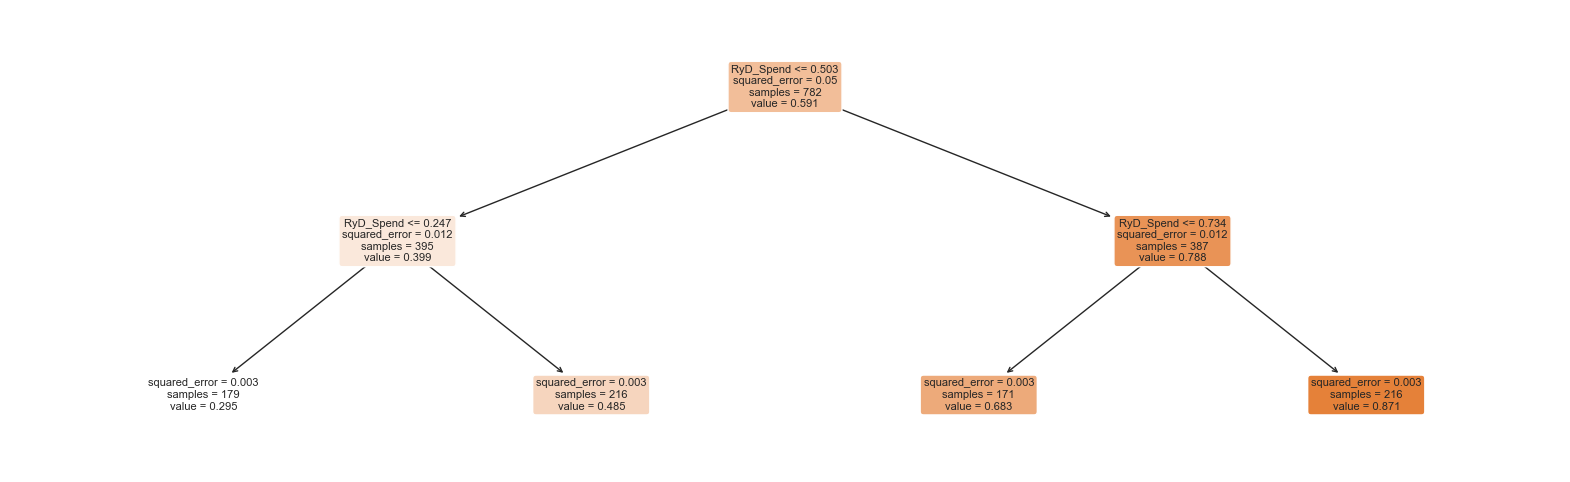

In [40]:
features = feature_list

plt.figure(figsize=(20,6))
tree.plot_tree(best_model,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()

# Conclusión
Para realizar la estandarización elegí MinMaxScaler para estandarizar los datos porque asegura que todas las características estén en la misma escala y dentro del rango [0, 1]. Esto es crucial para los algoritmos de aprendizaje automático, ya que son sensibles a las diferencias de escala entre las características.

Para encontrar los mejores valores utilicé GridSearchCV ya que es una herramienta poderosa para encontrar la mejor combinación de hiperparámetros, garantizando una exploración exhaustiva y automatizada que mejora la eficiencia y la eficacia del proceso de ajuste del modelo.

En la regresión lineal sin hiperparámetros se observa por el r2 que se realizó overfitting, siendo de 0.97 y luego de la optimización de los mismos el r2 es de 0.93

# Dataset de Pokemon

In [41]:
df = pd.read_csv('data/PokemonDB.csv')

In [42]:
df

,Name,Type,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,45,49,49,65,65,45
1,Ivysaur,Grass,60,62,63,80,80,60
2,Venusaur,Grass,80,82,83,100,100,80
3,Venusaur,Grass,80,100,123,122,120,80
4,Charmander,Fire,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...
1185,Chi-Yu,Dark,55,80,80,135,120,100
1186,Roaring Moon,Dragon,105,139,71,55,101,119
1187,Iron Valiant,Fairy,74,130,90,120,60,116
1188,Koraidon,Fighting,100,135,115,85,100,135


## Exploración de datos
### Información del dataset (datos nulos y tipos de datos por columna)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     1190 non-null   object
 1   Type     1190 non-null   object
 2   HP       1190 non-null   int64 
 3   Attack   1190 non-null   int64 
 4   Defense  1190 non-null   int64 
 5   Sp. Atk  1190 non-null   int64 
 6   Sp. Def  1190 non-null   int64 
 7   Speed    1190 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 74.5+ KB


### Se puede observar que el dataset cuenta con un total de 1190 datos, los mismos son de tipo int64 y las variables name y type de tipo object
### No hay presencia de valores nulos

## Descripción estadística de los datos (min, max, media, mediana, etc.)

In [44]:
df.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,70.852941,80.957983,74.586555,72.756303,72.050420,69.695798
std,26.886443,32.119650,30.718212,32.658636,27.637522,30.204376
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,51.250000,56.000000,51.000000,50.000000,50.000000,45.000000
50%,70.000000,80.000000,70.000000,65.000000,70.000000,67.000000
75%,85.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,255.000000,190.000000,250.000000,194.000000,250.000000,200.000000


## Histogramas

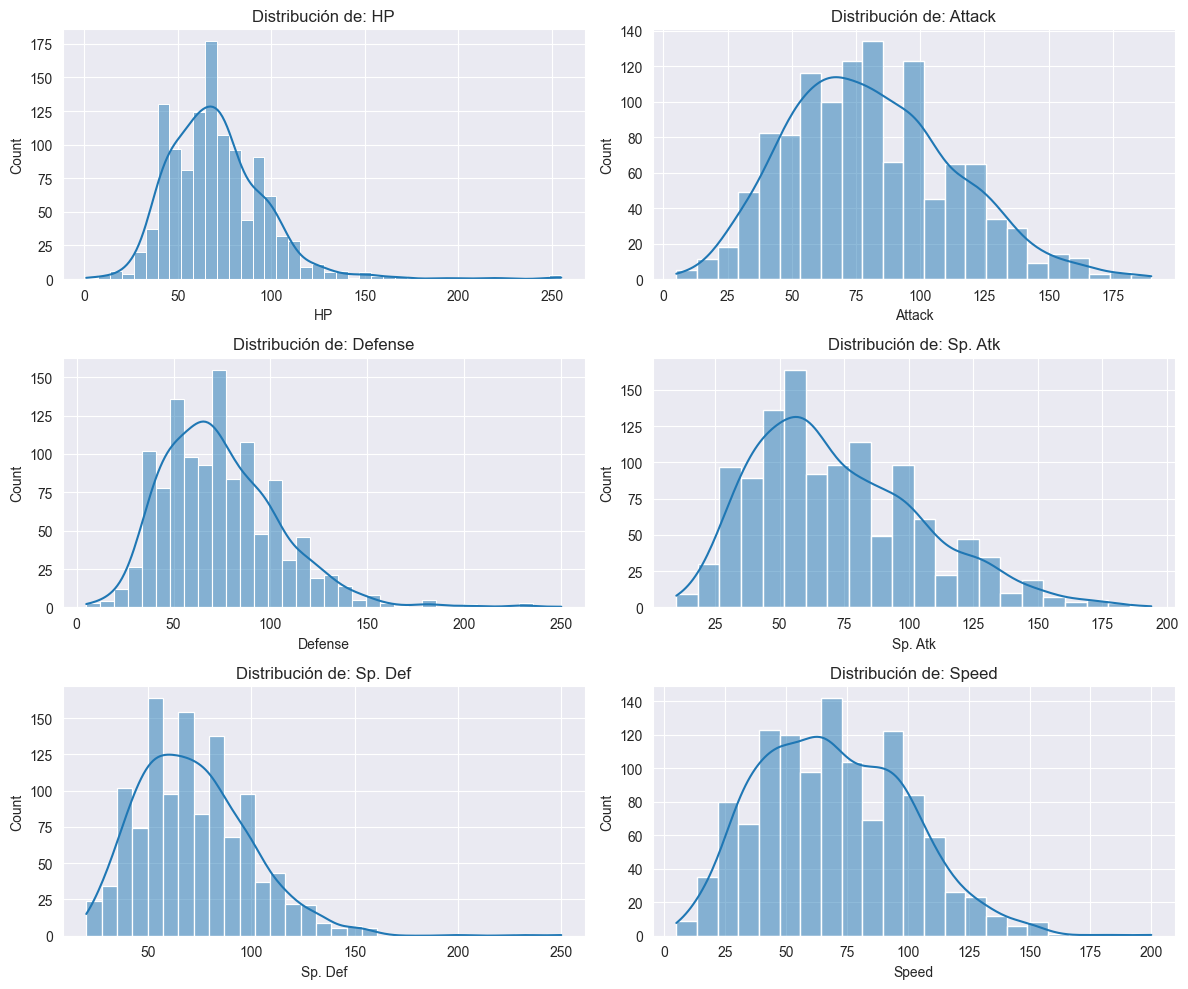

In [45]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 10))
for i, column in enumerate(numeric_columns):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribución de: {column}')
plt.tight_layout()
plt.show()

En los histogramas puedo observar que las distribuciones se asemejan a la normal presentando un leve sesgo hacia la derecha. 

### Matriz de correlación

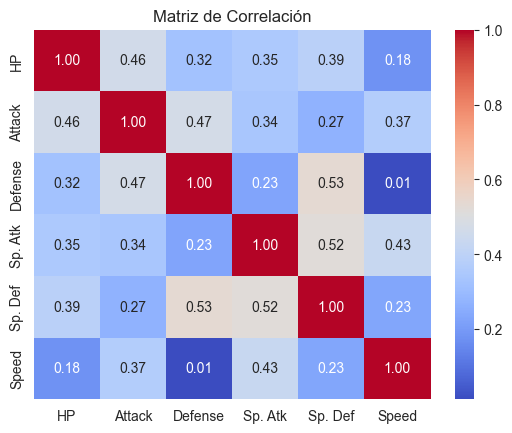

In [46]:
columnas_numericas = df.select_dtypes(include='number')
matriz_correlacion = columnas_numericas.corr()

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.ylim(len(matriz_correlacion), 0)
plt.xlim(0, len(matriz_correlacion))
plt.title("Matriz de Correlación")
plt.show()

Todas las variables presentan correlacion lineal positiva, entre ellas, las mayores son:

Sp. Def - Defense (0.53)

Sp. Atk - Defense (0.52)

Defense - Attack (0.47)

Attack - HP (0.46)

# Boxplot

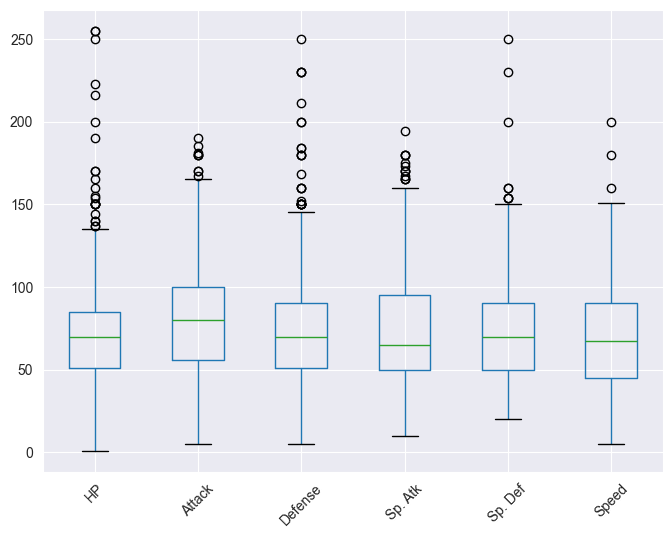

In [47]:
plt.figure(figsize=(8, 6))
df.boxplot(figsize=(12, 8))
plt.xticks(rotation=45)
plt.show()

### Se observa presencia de valores que aparentan ser outliers, a continuación investigo a que pokemon pertenecen para poder realizar un mejor análisis
### Reviso los datos que aparentan ser outliers en cada una de las columnas, dejo como ejemplo HP

In [48]:
# Calcular el rango intercuartílico (IQR)
Q1 = df['HP'].quantile(0.25)
Q3 = df['HP'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los valores atípicos
outliers = df[(df['HP'] < lower_bound) | (df['HP'] > upper_bound)]

print("Valores atípicos en la columna 'HP':")
print(outliers)


Valores atípicos en la columna 'HP':
            Name      Type   HP  Attack  Defense  Sp. Atk  Sp. Def  Speed
53    Wigglytuff    Normal  140      70       45       85       50     45
151      Chansey    Normal  250       5        5       35      105     50
190      Snorlax    Normal  160     110       65       65      110     30
258    Wobbuffet   Psychic  190      33       58       33       58     33
305      Blissey    Normal  255      10       10       75      135     55
359      Slaking    Normal  150     160      100       95       65    100
367     Hariyama  Fighting  144     120       60       40       60     50
397      Wailord     Water  170      90       45       90       45     60
524     Drifblim     Ghost  150      80       44       90       54     80
597     Giratina     Ghost  150     100      120      100      120     90
598     Giratina     Ghost  150     120      100      120      100     90
718    Alomomola     Water  165      75       80       40       45     65
8

### Revise los datos de los Pokemon que aparentan ser outliers comparandolos con los del sitio web https://www.wikidex.net/wiki/Ferropalmas y son datos correctos

## Realizo un gráfico de barras para la variable type

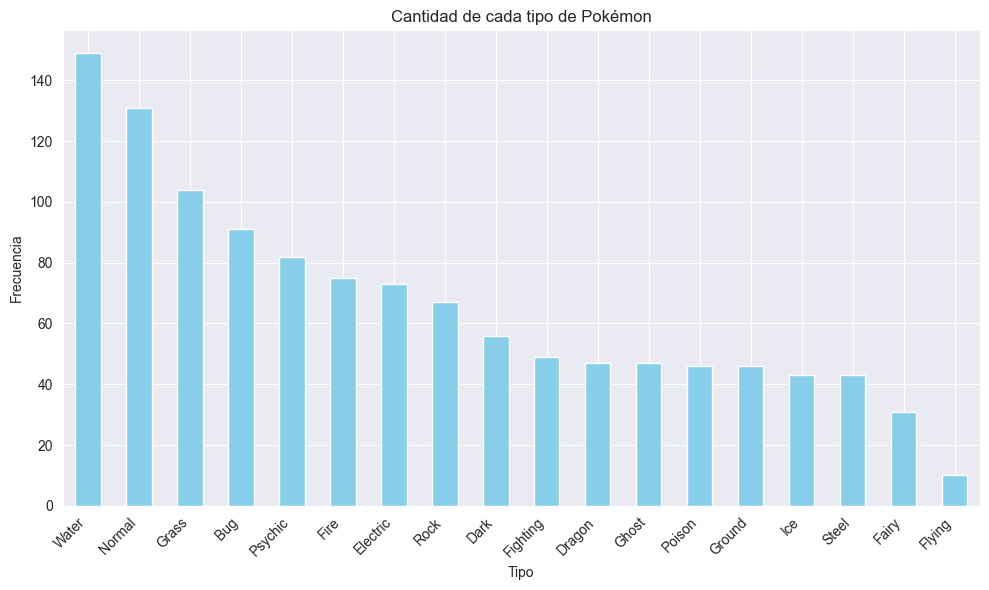

In [49]:
type_counts = df['Type'].value_counts()

plt.figure(figsize=(10, 6)) 
type_counts.plot(kind='bar', color='skyblue')
plt.title('Cantidad de cada tipo de Pokémon')
plt.xlabel('Tipo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Se puede observar que hay un alto nivel de desbalanceo entre las diferentes categorías.

## Divido en conjuntos de Entrenamiento y Prueba

In [50]:
df_train, df_test,  = train_test_split(df, test_size=0.2, random_state=42)

In [51]:
# Extraer las etiquetas (variable objetivo) de la columna 'Type' en los DataFrames 'df_train' y 'df_test', y convertirlas en arreglos NumPy.
train_labels = np.array(df_train['Type'])
test_labels = np.array(df_test['Type'])

# Elimino las etiquetas para separar las características (variables independientes) de la variable objetivo.
df_train = df_train.drop(['Type', 'Name'], axis = 1)
df_test = df_test.drop(['Type', 'Name'], axis = 1)

# Lista de nombres de características extrayendo los nombres de columna del DataFrame 'df_train' para usarlos luego.
feature_list = list(df_train.columns)

# Convierte los DataFrames modificados (sin la columna 'Type') es decir, las características (variables independientes) a array.
train_features = np.array(df_train)
test_features = np.array(df_test)

In [52]:
clf = tree.DecisionTreeClassifier()

In [53]:
#Entreno el modelo pasando las características de entrenamiento (train_features) y las etiquetas de entrenamiento correspondientes (train_labels).
decision_tree = clf.fit(train_features, train_labels)

# Predicción en el conjunto de entrenamiento
clf_predictions_train = clf.predict(train_features)

# Predicción en el conjunto de prueba
clf_predictions = clf.predict(test_features)

In [54]:
#Evaluo el rendimiento del modelo
train_accuracy = accuracy_score(train_labels, clf_predictions_train)
test_accuracy = accuracy_score(test_labels, clf_predictions)

In [55]:
print('train_accuracy: ', train_accuracy, 'test_accuracy: ', test_accuracy)

train_accuracy:  0.976890756302521 test_accuracy:  0.15126050420168066


### El modelo ajusta muy bien en el conjunto de entrenamiento pero un valor muy inferior en el conjunto de prueba, es probable que esté sobreajustando (overfitting) los datos de entrenamiento.

In [56]:
r = export_text(decision_tree, feature_names=feature_list)
print(r)

|--- Sp. Atk <= 61.50
|   |--- Defense <= 99.50
|   |   |--- Sp. Atk <= 29.50
|   |   |   |--- Attack <= 47.50
|   |   |   |   |--- HP <= 52.50
|   |   |   |   |   |--- Sp. Atk <= 17.50
|   |   |   |   |   |   |--- class: Water
|   |   |   |   |   |--- Sp. Atk >  17.50
|   |   |   |   |   |   |--- Attack <= 21.00
|   |   |   |   |   |   |   |--- Sp. Atk <= 22.50
|   |   |   |   |   |   |   |   |--- class: Normal
|   |   |   |   |   |   |   |--- Sp. Atk >  22.50
|   |   |   |   |   |   |   |   |--- HP <= 35.00
|   |   |   |   |   |   |   |   |   |--- class: Bug
|   |   |   |   |   |   |   |   |--- HP >  35.00
|   |   |   |   |   |   |   |   |   |--- Speed <= 35.00
|   |   |   |   |   |   |   |   |   |   |--- class: Bug
|   |   |   |   |   |   |   |   |   |--- Speed >  35.00
|   |   |   |   |   |   |   |   |   |   |--- class: Water
|   |   |   |   |   |   |--- Attack >  21.00
|   |   |   |   |   |   |   |--- Defense <= 33.00
|   |   |   |   |   |   |   |   |--- Attack <= 32.00
|   |   | 

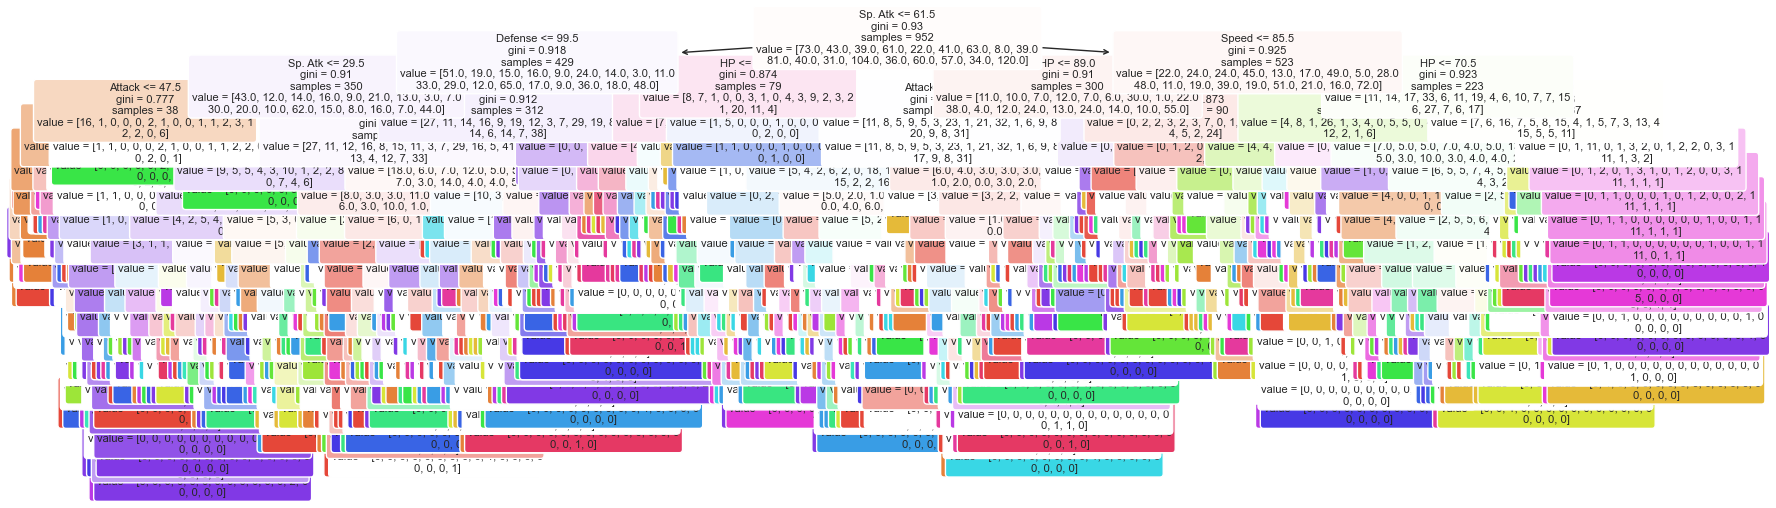

In [57]:
features = feature_list

plt.figure(figsize=(20,6))
tree.plot_tree(decision_tree,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()

## Optimización de hiperparámetros

In [58]:
# max_depth: La profundidad máxima del árbol.
# max_features: El número máximo de características a considerar para cada división. Suele ser la raíz cuadrada del número de características.
# min_samples_split: El número mínimo de muestras necesarias para dividir un nodo interno.
# random_state: Semilla para la generación de números aleatorios.

param_grid = {
    'max_features': [3, 5, 6, 7, 9],
    'max_depth': [6, 9, 10, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}
random_search = RandomizedSearchCV(tree.DecisionTreeClassifier(),
                                   param_grid)
random_search.fit(train_features, train_labels)
first_best_params = random_search.best_params_ # Mejores hiperparámetros encontrados durante la búsqueda aleatoria
best_prediction = random_search.predict(test_features) #Entrenamos el modelo con estos hiperparametros

test_accuracy = accuracy_score(test_labels, best_prediction)

precision = precision_score(test_labels, best_prediction, average='weighted', zero_division=0)

# Calcular la exhaustividad del modelo
recall = recall_score(test_labels, best_prediction, average='weighted')

# Calcular la exactitud del modelo
accuracy = accuracy_score(test_labels, best_prediction)

# Mostrar las métricas
print(f'Precisión del modelo: {precision}')
print(f'Exhaustividad del modelo: {recall}')
print(f'Exactitud del modelo: {accuracy}')

Precisión del modelo: 0.12192440941823048
Exhaustividad del modelo: 0.14705882352941177
Exactitud del modelo: 0.14705882352941177


Métricas sobre el primer conjunto de prueba:
Precisión: 0.15173184658478775
Exhaustividad: 0.14285714285714285
Exactitud: 0.14285714285714285

Métricas sobre el segundo conjunto de prueba:
Precisión: 0.10820895477346293
Exhaustividad: 0.15126050420168066
Exactitud: 0.15126050420168066


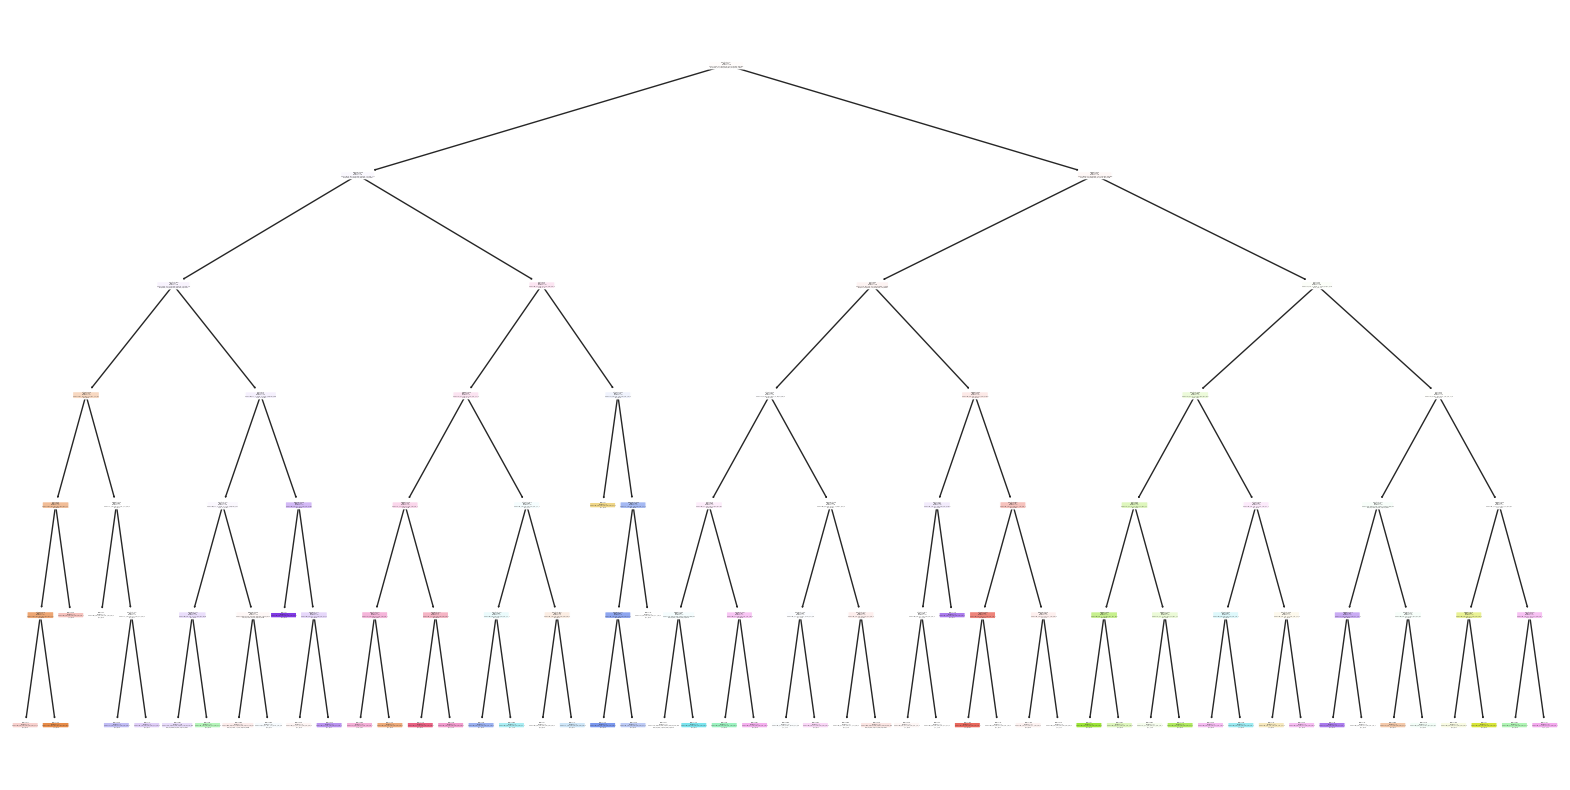

In [59]:
test_features1, test_features2, test_labels1, test_labels2 = train_test_split(test_features, test_labels, test_size=0.5, random_state=42)

# Calcular las métricas sobre el primer conjunto de prueba
predictions_test1 = random_search.predict(test_features1)
precision_test1 = precision_score(test_labels1, predictions_test1, average='weighted', zero_division=0)
recall_test1 = recall_score(test_labels1, predictions_test1, average='weighted')
accuracy_test1 = accuracy_score(test_labels1, predictions_test1)

# Calcular las métricas sobre el segundo conjunto de prueba
predictions_test2 = random_search.predict(test_features2)
precision_test2 = precision_score(test_labels2, predictions_test2, average='weighted', zero_division=0)
recall_test2 = recall_score(test_labels2, predictions_test2, average='weighted')
accuracy_test2 = accuracy_score(test_labels2, predictions_test2)

# Mostrar las métricas
print("Métricas sobre el primer conjunto de prueba:")
print(f'Precisión: {precision_test1}')
print(f'Exhaustividad: {recall_test1}')
print(f'Exactitud: {accuracy_test1}')
print("\nMétricas sobre el segundo conjunto de prueba:")
print(f'Precisión: {precision_test2}')
print(f'Exhaustividad: {recall_test2}')
print(f'Exactitud: {accuracy_test2}')

# Graficar el árbol obtenido durante el proceso de entrenamiento
plt.figure(figsize=(20, 10))
plot_tree(random_search.best_estimator_, feature_names=feature_list, filled=True, rounded=True)
plt.show()


# Metricas

In [60]:
accuracy = accuracy_score(test_labels, clf_predictions)
precision = precision_score(test_labels, clf_predictions, average='macro')
recall = recall_score(test_labels, clf_predictions, average='macro')
f1 = f1_score(test_labels, clf_predictions, average='macro')
confusion = confusion_matrix(test_labels, clf_predictions)


In [61]:
print(f'Accuracy: {accuracy},\n\nPrecision: {precision},\n\nRecall: {recall},\n\nF1 {f1}')


Accuracy: 0.15126050420168066,

Precision: 0.11109612572981933,

Recall: 0.1131160149442675,

F1 0.10956136615383232


## Bayes Ingenuo

Vamos a probar GaussianNB en primer lugar, porque no requiere discretizar los datos y puede manejar características continuas como las obtenidas luego de estandarizar

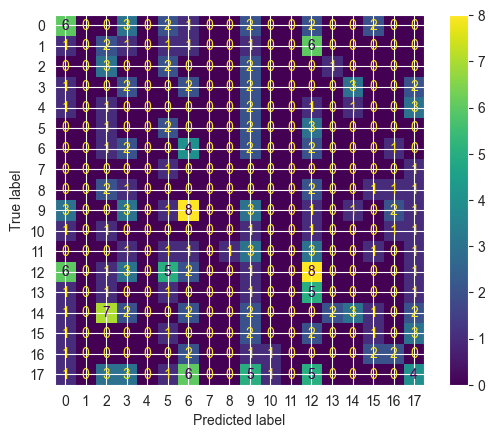

In [62]:
# Dividir el conjunto de datos en entrenamiento y prueba
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Extraer etiquetas de clase
train_labels = np.array(df_train['Type'])
test_labels = np.array(df_test['Type'])

# Eliminar las etiquetas para separar las características
df_train = df_train.drop(['Type', 'Name'], axis=1)
df_test = df_test.drop(['Type', 'Name'], axis=1)

# Lista de nombres de características
feature_list = list(df_train.columns)

# Convertir los DataFrames a arrays
train_features = np.array(df_train)
test_features = np.array(df_test)

# Codificar etiquetas de clase
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Entrenar el modelo GaussianNB
model_GaussianNB = GaussianNB()
model_GaussianNB.fit(train_features, train_labels_encoded)

# Realizar predicciones en el conjunto de prueba
y_pred_GNB = model_GaussianNB.predict(test_features)
y_train_GNB = model_GaussianNB.predict(train_features)
# Crear la matriz de confusión
cm_GNB = metrics.confusion_matrix(test_labels_encoded, y_pred_GNB)

# Visualizar la matriz de confusión
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_GNB).plot()


In [63]:
# Calcular precision, exactitud y recuperación
precision = precision_score(test_labels_encoded, y_pred_GNB, average='weighted', zero_division=0)
accuracy = accuracy_score(test_labels_encoded, y_pred_GNB)
recall = recall_score(test_labels_encoded, y_pred_GNB, average='weighted', zero_division=0)

# Mostrar las métricas
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')


Precision: 0.14390830875871272
Accuracy: 0.15966386554621848
Recall: 0.15966386554621848


# K-NN

In [64]:
knn_model = KNeighborsClassifier(n_neighbors=3)
# Entrenar el modelo
knn_model.fit(train_features, train_labels_encoded)

KNeighborsClassifier(n_neighbors=3)

In [65]:
predictions = knn_model.predict(test_features)
accuracy = accuracy_score(test_labels_encoded, predictions)
recall = recall_score(test_labels_encoded, predictions, average='weighted', zero_division=0)
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')

Precision: 0.14390830875871272
Accuracy: 0.13445378151260504
Recall: 0.13445378151260504


# KNN & GridSearchCV

In [66]:
# Inicializar el clasificador KNN
knn_model_GSCV = KNeighborsClassifier()

# Definir los parámetros a ajustar
parametros_grid = {'n_neighbors':  range(1, 15, 2),
                   'p':[1,2],
                   'weights': ['uniform', 'distance'] }

# Inicializar el objeto GridSearchCV
grid_search = GridSearchCV(estimator = knn_model_GSCV,
                           param_grid = parametros_grid,
                           cv=5,
                           scoring='accuracy')

# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
grid_search.fit(train_features, train_labels_encoded)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo entrenado
mejor_modelo = grid_search.best_estimator_

Mejores hiperparámetros: {'n_neighbors': 13, 'p': 2, 'weights': 'distance'}


In [67]:
# Realizar predicciones en el conjunto de prueba
predictions = mejor_modelo.predict(test_features)
accuracy = accuracy_score(test_labels_encoded, predictions)
recall = recall_score(test_labels_encoded, predictions, average='weighted', zero_division=0)
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')

Precision: 0.14390830875871272
Accuracy: 0.2184873949579832
Recall: 0.2184873949579832


## Conclusión: 

En este análisis, exploré varios modelos de clasificación, incluyendo Árbol de Decisión, Bayes Ingenuo y k-NN, con el propósito de predecir la variable "Type" en un conjunto de datos estandarizado. Me enfoque en la optimización de hiperparámetros para tratar de mejorar las métricas de rendimiento de cada modelo.

A pesar de que se logran mejores resultados en accuracy y recall cuando se optimizan los hiperparámetros, las métricas de rendimiento indican que los modelos ajustan muy mal. La pobre performance de estos, puede deberse a la cantidad limitada de datos y al alto nivel de desbalanceo existente entre las diferentes categorías. 
